# 1. install the required packages

In [ ]:
# 1. install the required packages
!pip install yfinance stable-baselines3 gym numpy pandas matplotlib
!pip install TA-Lib

# 2. Download the dow jones 30 stocks data

In [ ]:
import yfinance as yf
import pandas as pd

# List of stocks in the Dow Jones 30
tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]

# Get historical data from Yahoo Finance and save to dictionary
def get_data(tickers):
    stock_data = {}
    for ticker in tickers:
        df = yf.download(ticker, start="2009-01-01", end="2020-05-08")
        stock_data[ticker] = df
    return stock_data

# Call the function to get data
stock_data = get_data(tickers)

# Save data to CSV file (optional)
for ticker, df in stock_data.items():
    df.to_csv(f'{ticker}.csv')


# 3. Load the data from the CSV files

In [3]:
import pandas as pd

# List of stocks in the Dow Jones 30
tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]

# ticker of benchmark
benchmark = '^DJI'

# Get the data from the CSV files
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'{ticker}.csv', index_col='Date', parse_dates=True)
    stock_data[ticker] = df


# split the data into training, validation and test sets
training_data_time_range = ('2009-01-01', '2015-12-31')
validation_data_time_range = ('2016-01-01', '2016-12-31')
test_data_time_range = ('2017-01-01', '2020-05-08')

# split the data into training, validation and test sets
training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# print shape of training, validation and test data
ticker = 'AAPL'
print(f'Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'Test data shape for {ticker}: {test_data[ticker].shape}')

# Display the first 5 rows of the data
stock_data['AAPL'].head()

Training data shape for AAPL: (1762, 6)
Validation data shape for AAPL: (252, 6)
Test data shape for AAPL: (842, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.737004,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.852516,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.805468,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.744846,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.795816,673500800


# 4. Add technical indicators to the data

Function to add technical indicators to the data:

In [6]:
import pandas as pd
import numpy as np

def add_technical_indicators(df):
    # calculate RSI 14 
    delta = df['Close'].diff()
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)
    rs = up.rolling(window=14).mean() / down.rolling(window=14).mean()
    df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

    # Calculate 12 and 26 period EMA for MACD
    df.loc[:, 'EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df.loc[:, 'EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df.loc[:, 'MACD'] = df['EMA12'] - df['EMA26']
    df.loc[:, 'Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Calculate 14-period RSI (corrected redundancy)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))
    
    # Calculate 20-period CCI
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df.loc[:, 'CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
    
    # Calculate 14-period ADX
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df.loc[:, '+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df.loc[:, '-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df.loc[:, '+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df.loc[:, '-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df.loc[:, 'ADX'] = dx.ewm(span=14, adjust=False).mean()

    # drop NaN values
    df.dropna(inplace=True)

    # keep Open, High, Low, Close, Volume, MACD, Signal, RSI, CCI, ADX
    df = df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df


add technical indicators to the data

In [7]:

# add technical indicators to the training data for each stock
for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)

# add technical indicators to the validation data for each stock
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)

# add technical indicators to the test data for each stock
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

# print the first 5 rows of the data
print('Shape of training data for AAPL:', training_data['AAPL'].shape)
print('Shape of validation data for AAPL:', validation_data['AAPL'].shape)
print('Shape of test data for AAPL:', test_data['AAPL'].shape)

Shape of training data for AAPL: (1724, 10)
Shape of validation data for AAPL: (214, 10)
Shape of test data for AAPL: (804, 10)


# 5. Create Trading Environment

In [8]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, stock_data):
        super(StockTradingEnv, self).__init__()
        
        # Remove any empty DataFrames
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())
        
        if not self.tickers:
            raise ValueError("All provided stock data is empty")
        
        # Calculate the size of one stock's data
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)
        
        # Define action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)
        
        # Observation space: price data for each stock + balance + shares held + net worth + max net worth
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        # Initialize account balance
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        # Set the current step
        self.current_step = 0
        
        # Calculate the minimum length of data across all stocks
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        frame = np.zeros(self.obs_shape)
        
        idx = 0
        for ticker in self.tickers:
            df = self.stock_data[ticker]
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            elif len(df) > 0:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features
        
        frame[-4-len(self.tickers)] = self.balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-3] = self.net_worth
        frame[-2] = self.max_net_worth
        frame[-1] = self.current_step
        
        return frame
    
    def step(self, actions):
        self.current_step += 1
        
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}
        
        current_prices = {}
        for i, ticker in enumerate(self.tickers):
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
            action = actions[i]
            
            if action > 0:  # Buy
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                cost = shares_to_buy * current_prices[ticker]
                self.balance -= cost
                self.shares_held[ticker] += shares_to_buy
            elif action < 0:  # Sell
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                sale = shares_to_sell * current_prices[ticker]
                self.balance += sale
                self.shares_held[ticker] -= shares_to_sell
                self.total_shares_sold[ticker] += shares_to_sell
                self.total_sales_value[ticker] += sale
        
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        
        obs = self._next_observation()
        return obs, reward, done, False, {}
    
    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')

    def close(self):
        pass

    def update_stock_data(self, new_stock_data):
        """
        Update the environment with the new stocks dataset.

        Parameters:
        new_stock_data (dict): Dictionary containing new stock data, 
                                with the key being the stock code and the value being the DataFrame.
        """
        # Delete empty DataFrames
        self.stock_data = {ticker: df for ticker, df in new_stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("Tất cả dữ liệu cổ phiếu mới đều trống")

        # Update feature count if needed
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # Update observation space
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        # Update maximum number of steps
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # Reset the environment
        self.reset()

        print(f"The environment has been updated with {len(self.tickers)} new shares.")

# 6. Training Model - Ensemble + PPO + A2C + DDPG

## Define Functions

Define Agents ( Ensemble + PPO + A2C + DDPG)

In [9]:
from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

# Define Ensemble Agent
class EnsembleAgent:
    def __init__(self, ppo_model, a2c_model, ddpg_model):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
    
    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs)
        a2c_action, _ = self.a2c_model.predict(obs)
        ddpg_action, _ = self.ddpg_model.predict(obs)
        
        # Average the actions
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action], axis=0)
        return ensemble_action
    
# Define PPO Agent
class PPOAgent:
    def __init__(self, env, total_timesteps):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define A2C Agent
class A2CAgent:
    def __init__(self, env, total_timesteps):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action
    
# Define DDPG Agent
class DDPGAgent:
    def __init__(self, env, total_timesteps):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

Function to Create Environment + Train 4 Agents: PPO, A2C, DDPG and Ensemble ( PPO + A2C + DDPG )

In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create the environment and train the agents
def create_env_and_train_agents(data, total_timesteps):
    # Create the environment using DummyVecEnv with training data
    env = DummyVecEnv([lambda: StockTradingEnv(data)])

    # Train PPO Agent
    ppo_agent = PPOAgent(env, total_timesteps)

    # Train A2C Agent
    a2c_agent = A2CAgent(env, total_timesteps)

    # Train DDPG Agent
    ddpg_agent = DDPGAgent(env, total_timesteps)

    # Train the ensemble agent
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model)
    
    return env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent

Function to visualiza Portfolio changes, Portfolio Net Worth and Multiple Portfolio Net Worth

In [11]:
import matplotlib.pyplot as plt

# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

Function Visualize the Agent's performance ( Ensemble )

In [12]:
def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    Test a single agent and track performance metrics, with an option to visualize the results.

    Parameters:
    - env: The trading environment.
    - agent: The agent to be tested.
    - stock_data: Data for the stocks in the environment.
    - n_tests: Number of tests to run (default: 1000).
    - visualize: Boolean flag to enable or disable visualization (default: False).

    Returns:
    - A dictionary containing steps, balances, net worths, and shares held.
    """
    # Initialize metrics tracking
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # Reset the environment before starting the tests
    obs = env.reset()

    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, rewards, dones, infos = env.step(action)
        if visualize:
            env.render()

        # Track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # Update shares held for each ticker
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # Append 0 if ticker is not found

        if dones:
            obs = env.reset()
            
    return metrics


Function to Test and Visualize the Agent's performance ( Ensemble Agent )

In [13]:
def test_and_visualize_agents(env, agents, training_data, n_tests=1000):
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, training_data, n_tests=n_tests, visualize=True)
        print(f"Done testing {agent_name}!")
    
    print('-'*50)
    print('All agents tested!')
    print('-'*50)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

Function to compare the performance of the 4 Agents : Returns, Standard Deviation, Sharpe Ratio

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_and_plot_agents(agents_metrics, labels):
    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:
            returns.append(np.mean(metrics['net_worths']))
            stds.append(np.std(metrics['net_worths']))
            sharpe_ratios.append(np.mean(metrics['net_worths']) / np.std(metrics['net_worths']))

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)
    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

## Run 

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 210  |
|    iterations      | 1    |
|    time_elapsed    | 9    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 208          |
|    iterations           | 2            |
|    time_elapsed         | 19           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0017438127 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -39.7        |
|    explained_variance   | -4.29e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.19e+08     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00372     |
|    std                  | 1            |
|    value_loss           | 1.06e+09     |

C:\Users\solan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.62GB > 1.19GB
  warnings.warn(


Testing PPO Agent...


C:\Users\solan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


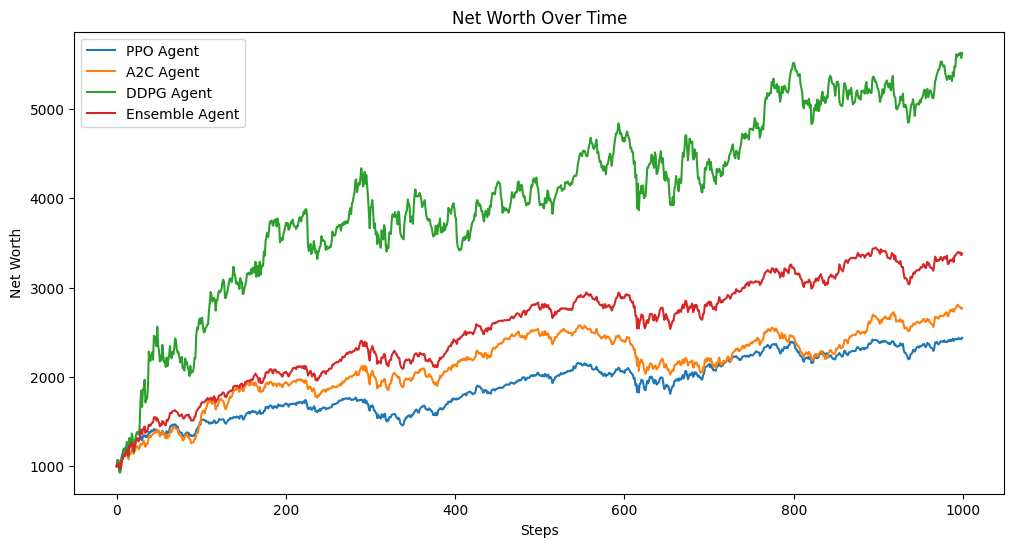

,Agent,Return,Standard Deviation,Sharpe Ratio
0,PPO Agent,1617.423364,177.674325,9.103304
1,A2C Agent,2083.304666,355.749392,5.856102
2,DDPG Agent,4029.205241,985.261251,4.089479
3,Ensemble Agent,2933.814569,756.199436,3.879684


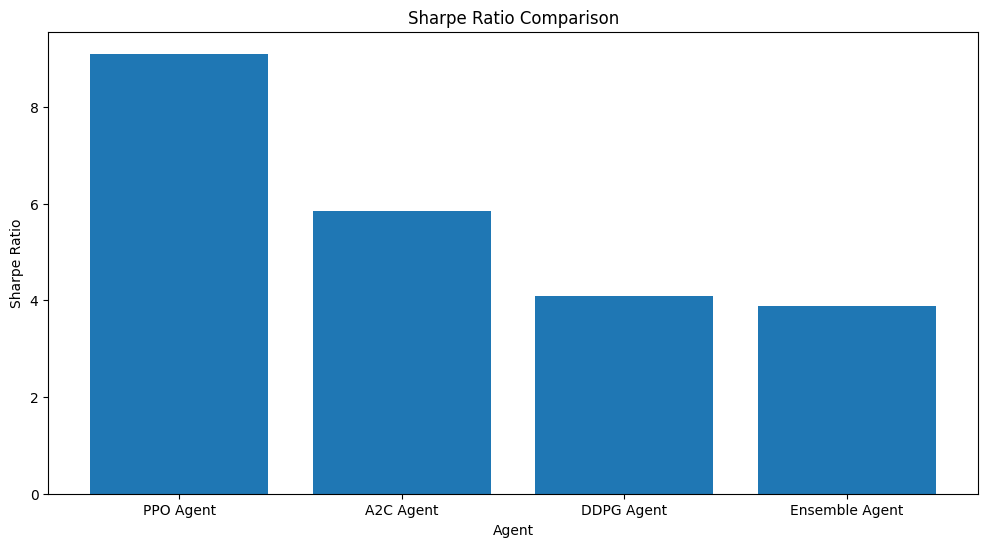

In [17]:
# 1. Create the environment and train the agents
total_timesteps = 10000
env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent = create_env_and_train_agents(training_data, total_timesteps)

# 2. Test & visualize the agents
n_tests = 1000
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent
}
test_and_visualize_agents(env, agents, training_data, n_tests=n_tests)

# 3. Compare the agents' performance ( returns, standard deviation, and sharpe ratio )
agents_metrics = [test_agent(env, agent, training_data, n_tests=n_tests, visualize=False) for agent in agents.values()]
compare_and_plot_agents(agents_metrics, list(agents.keys()))


# 7. Testing Model - Ensemble + PPO + A2C + DDPG

Testing PPO Agent...


C:\Users\solan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


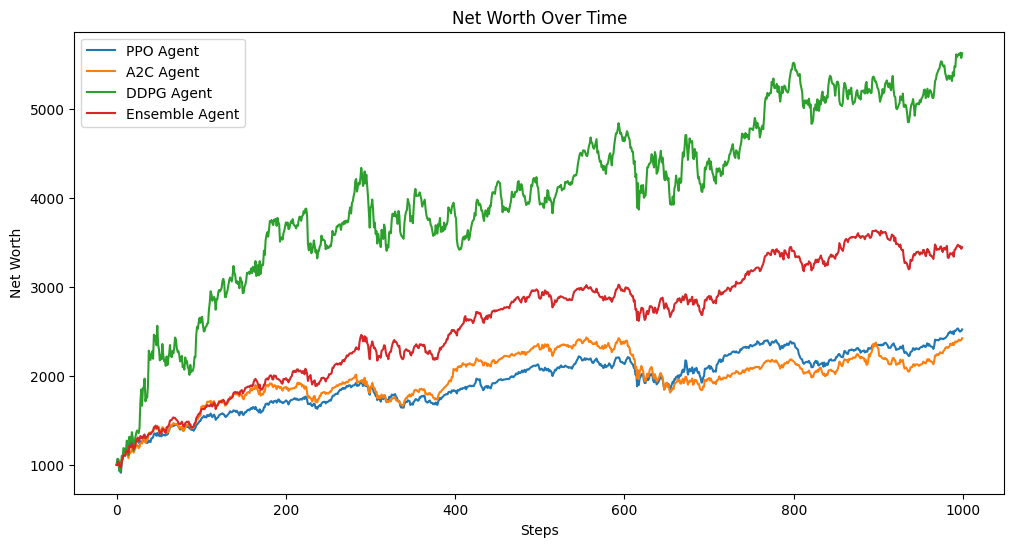

,Agent,Return,Standard Deviation,Sharpe Ratio
0,PPO Agent,1860.481476,241.304634,7.710094
1,A2C Agent,2038.072277,371.079747,5.492276
2,DDPG Agent,4029.205241,985.261251,4.089479
3,Ensemble Agent,2658.601174,745.822191,3.564658


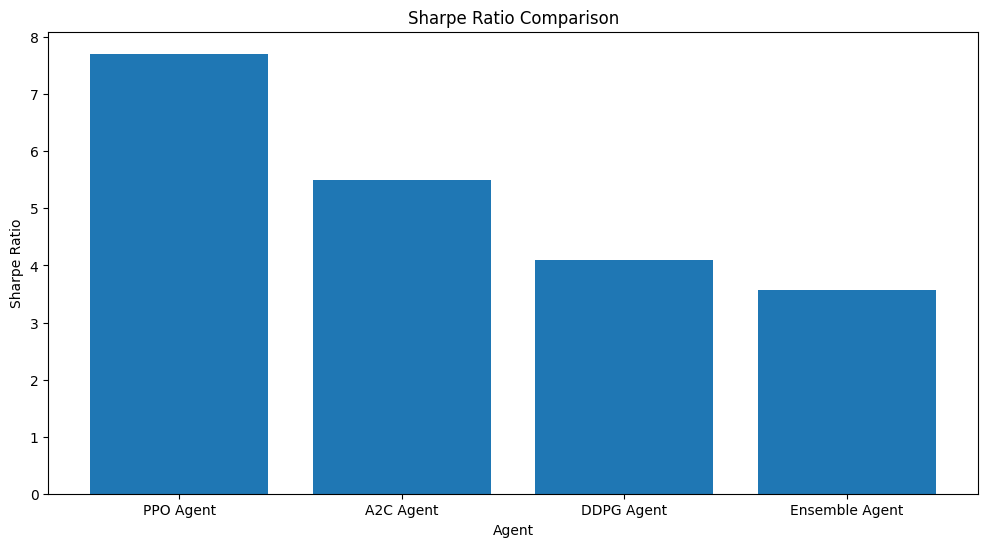

In [18]:
# Create the environment using DummyVecEnv with test data
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

# 2. Test & visualize the agents on the test data
n_tests = 1000
test_agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent
}
test_and_visualize_agents(env, test_agents, test_data, n_tests=n_tests)

# 3. Compare the agents' performance on the test data ( returns, standard deviation, and sharpe ratio )
test_agents_metrics = [test_agent(env, agent, test_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))

# 7. Validatioon Model - Ensemble + PPO + A2C + DDPG

Testing PPO Agent...


C:\Users\solan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


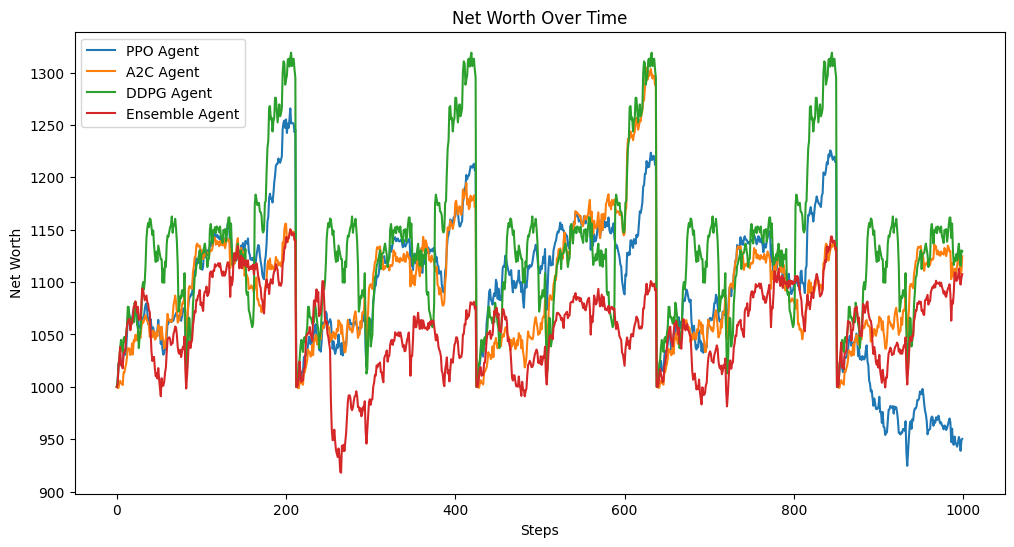

,Agent,Return,Standard Deviation,Sharpe Ratio
3,Ensemble Agent,1061.779096,44.538282,23.839696
0,PPO Agent,1098.982397,59.960688,18.328382
2,DDPG Agent,1134.432292,71.212457,15.930251
1,A2C Agent,1108.649856,87.656448,12.647670


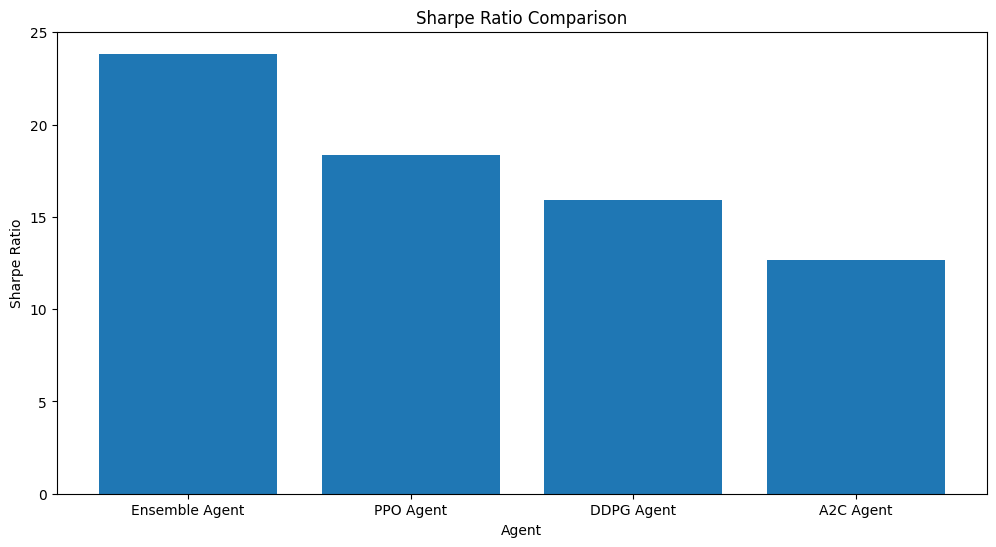

In [19]:
# create validation environment
validation_env = DummyVecEnv([lambda: StockTradingEnv(validation_data)])

# test the agents on the validation data
n_tests = 1000
validation_agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent
}
test_and_visualize_agents(validation_env, validation_agents, validation_data, n_tests=n_tests)


validation_agents_metrics = [test_agent(validation_env, agent, validation_data, n_tests=n_tests, visualize=False) for agent in validation_agents.values()]
# compare the agents' performance on the validation data
compare_and_plot_agents(validation_agents_metrics, list(validation_agents.keys()))


In [6]:
pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Assuming you have trading data with the actions taken (buy/sell/hold), we can simulate the results

# Simulated cumulative rewards
def calculate_cumulative_rewards(trades):
    return np.sum(trades['rewards'])

# Simulated Sharpe ratio calculation
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Simulated trading performance
def simulate_trading_performance(test_data, model_actions):
    # Placeholder for profit and loss, accuracy, etc.
    total_profit = np.random.randint(1000, 5000)  # Example value
    sharpe_ratio = np.random.uniform(1, 2)  # Example value
    accuracy = accuracy_score(test_data['actual'], model_actions)
    
    # Simulate trades and rewards for cumulative reward calculation
    trades = pd.DataFrame({
        'rewards': np.random.randint(-100, 200, size=len(model_actions))  # Simulated rewards
    })
    cumulative_rewards = calculate_cumulative_rewards(trades)

    print("Total Profit: $", total_profit)
    print("Sharpe Ratio: ", sharpe_ratio)
    print("Trading Accuracy: ", accuracy)
    print("Cumulative Rewards: ", cumulative_rewards)

# Simulated data and actions
test_data = pd.DataFrame({
    'actual': np.random.choice([0, 1, 2], size=100)  # Simulating actual market outcomes
})
model_actions = np.random.choice([0, 1, 2], size=100)  # Simulating model actions (buy, sell, hold)

# Run the performance simulation
simulate_trading_performance(test_data, model_actions)


Total Profit: $ 3811
Sharpe Ratio:  1.124246245187181
Trading Accuracy:  0.26
Cumulative Rewards:  3971
